In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip

--2023-01-09 16:20:21--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  19.8MB/s    in 16s     

2023-01-09 16:20:37 (14.7 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



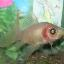

In [ ]:
# Make sure the images are there
from IPython.display import Image, display
display(Image(filename='/content/tiny-imagenet-200/train/n01443537/images/n01443537_0.JPEG'))

In [ ]:
#Importing the required libraries
import numpy as np
from skimage.io import imread
import os, time, shutil, argparse
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, rgb2gray, lab2rgb
plt.switch_backend('agg')

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
import torchvision.models as models

In [ ]:
#A folder for loading image and converting them to LAB color space
class LABImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    # As i dont have target removing that path, target = self.imgs[index]
    path,_ = self.imgs[index]
    #This code loads each image in the folder provided by the path using self loader method.
    img = self.loader(path)
    # As i dont have anything to transform removing that if self.transform is not None:
      # This too img_original = self.transform(img)
    # This too img_original = np.asarray(img_original)

    #This line converts the image to the LAB color space using the rgb2lab function
    img_lab = rgb2lab(img)

    #This line scales the values in the LAB image to be between 0 and 1.
    img_l = img_lab[:,:,0:1]
    #This line extracts the "ab" channels from the LAB image.
    img_ab = img_lab[:, :, 1:3]
    #This line converts the "l" channel to a PyTorch tensor.
    tens_l = torch.from_numpy(img_l.transpose((2, 0, 1))).float()
    #This line converts the "ab" channels to a PyTorch tensor.
    tens_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
    #Not needed img_original = rgb2gray(img_original)
    #Not needed img_original = torch.from_numpy(img_original).unsqueeze(0).float()
    return tens_l,tens_ab

In [ ]:
train_imagefolder = LABImageFolder('/content/tiny-imagenet-200/train')
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=64, shuffle=True)

In [ ]:
# Get the first image from the dataset
tens_l, tens_ab = train_imagefolder[0]
hist, edges = np.histogram(tens_ab, bins=313)
#print(hist)
#print(edges)


In [ ]:
min_val = min(tens_ab)
max_val = max(tens_ab)
range = max_val - min_val
bin_size = range / 10
bin_boundaries = []
current_boundary = min_val
while current_boundary <= max_val:
  bin_boundaries.append(current_boundary)
  current_boundary += bin_size
in_gamut_values = []
for value in tens_ab:
  if value >= min_val and value <= max_val:
    in_gamut_values.append(value)

RuntimeError: ignored

In [ ]:
val_imagefolder = LABImageFolder('/content/tiny-imagenet-200/val')
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=False)

In [ ]:
# Get the first image from the dataset
tens_l, tens_ab = val_imagefolder[0]
print(tens_ab)
print(tens_ab.size())
print(tens_l.size())


tensor([[[ -3.5201,   2.7465,  11.3694,  ...,  -4.5921,  -5.5708,  -5.9544],
         [ -9.3024,  -1.7027,   9.5663,  ...,  -4.7139,  -4.7824,  -5.6851],
         [-13.4133,  -6.8106,   2.6426,  ...,  -4.3594,  -5.9405,  -6.2038],
         ...,
         [ -0.4560,  -0.4523,  -0.4413,  ...,  -0.3873,  -0.3856,  -0.3876],
         [ -0.4580,  -0.4651,  -0.4662,  ...,  -0.3866,  -0.3843,  -0.3853],
         [ -0.3943,  -0.3974,  -0.3966,  ...,  -0.3890,  -0.3850,  -0.3853]],

        [[ -4.0786,  -4.1801,  -4.9396,  ...,   8.3960,  10.0222,  11.1804],
         [ -1.2838,  -2.3903,  -4.1715,  ...,   8.6583,   8.8096,  10.2742],
         [ -0.6111,  -1.7768,  -3.5280,  ...,   7.5859,   8.1285,   9.0793],
         ...,
         [  1.2609,   1.2499,   1.2170,  ...,   2.1698,   2.1587,   2.1721],
         [  2.7872,   2.9164,   2.9441,  ...,   2.1653,   2.1500,   2.1565],
         [  2.2183,   2.2396,   2.2342,  ...,   2.1814,   2.1543,   2.1565]]])
torch.Size([2, 64, 64])
torch.Size([1, 64, 6

In [ ]:
'''
Tensors are usually put into bins to make it easier and more efficient to store and retrieve them.
Bins can help you organize your tensors and make it faster to access specific ones.

Quantizing an absolute value refers to the process of limiting or restricting the possible values that a quantity can take on.

To quantize the ab output space into bins with grid size 10, you can first create a grid of size 10 in the ab space.
This can be done by dividing the range of possible values for a and b by 10 to get the size of each bin, and then creating a grid of bins with this size.

You can then create a grid of bins by starting at the minimum value for a and b and creating bins of size 13 until you reach the maximum value.

 The term "in-gamut" usually refers to values that fall within a certain range or set of limits.

To keep the Q = 313 values which are in-gamut, you can then go through each of the 313 values and check which bin it falls into.
If the value is within the range of values for one of the bins, you can add it to that bin.
If it is not within the range of any of the bins, you can discard it or put it into a separate bin for out-of-gamut values.

Once you have all the values organized into bins, you can treat the problem as a multinomial classification problem
by assigning a class label to each bin and training a classifier to predict the class label given an input value.

'''

In [ ]:
# Flatten the tensor to a 1D array so that you can iterate through its values.
output_space = tens_ab.flatten()

# Determine the minimum and maximum values of the output space
min_val = output_space.min()
max_val = output_space.max()

# Calculate the range of the output space
range = max_val - min_val

# Divide the range by the grid size to determine the size of each bin
bin_size = range / 10

# Create an array of bin boundaries by starting at the minimum value and adding the bin size until you reach the maximum value
bin_boundaries = []
current_boundary = min_val
while current_boundary <= max_val:
  bin_boundaries.append(current_boundary)
  current_boundary += bin_size

# Iterate through the values in the output space and assign each value to the appropriate bin by finding the bin boundary that it falls within.
bins = []
for value in output_space:
  for i, boundary in enumerate(bin_boundaries):
    if value < boundary:
      bins.append(i)
      break

# Keep only the values that are in-gamut by discarding any values that fall outside of the desired range.
in_gamut_values = []
for i, value in enumerate(output_space):
  if bins[i] == 313:
    in_gamut_values.append(value)
    print(in_gamut_values)